# 残差网络

## 1、动机
   
   ### a、基本问题描述
   
   在一定范围内随着神经网络随着层数增加可以更明确的学习出不同的特征从而提升网络性能。但是由于具体实现时其他问题的干扰导致普通的神经网络在增加层数到一定数量后再进行这样的操作反而会导致性能下降，如下图所示（摘自“Deep Residual Learning for Image Recognition”）：
   
   ![](./data/images/resnet1.jpg '深层网络问题')
   
   ### b、梯度消失与爆炸
   
   导致上述问题其中一个主要的原因就是“梯度消失与爆炸”，那么何为梯度消失于爆炸呢？
   
   **梯度消失**
   
    当前向传播的梯度绝对值小于1时，经过多层传播那么其指数性接近于零，导致网络靠前的网络层无法获取传播信息。导致此问题的原因主要有两个：一个是不恰当的选择“激活函数”（如sigmoid等，其在大部分区域梯度接近于0，选择类似“relu”函数等可以有效解决此问题），另一个就是网络过深，在梯度绝对值小于1时，经过多层传播那么其指数性接近于零。
    
   **梯度爆炸**
   
    同样由于网络过深当网络较深层梯度绝对值大于1那么在经过多层传播后可能出现指数增长从而超过计算机的表达范围出现训练问题导致系统性能的下降。此问题不是此处残差网络要解决的问题，解决此问题的是如“BatchNorlization”等等类似的方法。
    
   其实通过以上的描述我们可以了解到只有因为网络过深的“梯度消失”问题还无法有效解决，而“残差网络”的动机就是解决这个问题从而提升网络深度获得更好的性能。
    
## 2、残差网络
   
   ![](./data/images/resnet2.jpg '残差网络模型')
   
   以上为残差网络的简单模型（摘自“Deep Residual Learning for Image Recognition”）,这里我们将其看作一个两层网络，$X$是输入，
   
   **普通网络**
   $$z^{[1]} = W^{[1]}X$$
   $$a^{[1]} = relu(z^{[1]})$$
   $$z^{[2]} = W^{[2]}a^{[1]}$$
   $$a^{[2]} = relu(z^{[2]})$$
   
   **残差网络**
   $$z^{[1]} = W^{[1]}X$$
   $$a^{[1]} = relu(z^{[1]})$$
   $$z^{[2]} = W^{[2]}a^{[1]} + X$$
   $$a^{[2]} = relu(z^{[2]})$$
   
   如果对比$\frac{da^{[2]}}{dX}$则可见“残差网络”结果比普通网络多出一项常数项"1"，通过此方法保证梯度向前传播更多层。
   
   **具体实现“残差网络”时需要保证相加项维度相同，并且还有很多其他变种，但基本思想一致。**

# 3、残差网络应用

这里使用“残差网络”建立一个手势图片识别应用

## a、输入数据处理

In [1]:
import os,sys

if not ("%s/../.." % os.getcwd()) in sys.path:
    sys.path.append("%s/../.." % os.getcwd())

In [2]:
import numpy as np
from arsenal.data_process.load_data import DataHandler
from arsenal.data_process.plot_data import Ploter

import tensorflow as tf
from keras.initializers import glorot_uniform
from keras.layers.pooling import AveragePooling2D
from keras.layers.core import Flatten
from keras.layers import Input, Conv2D, BatchNormalization, Activation, ZeroPadding2D, MaxPooling2D, Dense, Add
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input

import scipy.misc

import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

%load_ext autoreload
%autoreload 2

np.random.seed(1)

/home/aln/tools/code/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


X trainset shape:  (1080, 64, 64, 3)
Y trainset shape:  (1080, 6)
X testset shape:  (120, 64, 64, 3)
Y testset shape:  (120, 6)


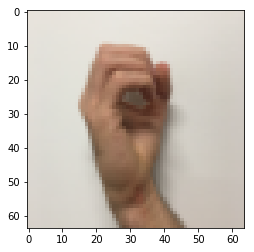

index:  20


In [3]:
train_dataset,train_dataset_keys = DataHandler().load("./data/train_signs.h5")
test_dataset,test_dataset_keys = DataHandler().load("./data/test_signs.h5")
X_train_orig, Y_train_orig = np.array(train_dataset['train_set_x']), np.array(train_dataset['train_set_y'])
X_test_orig, Y_test_orig = np.array(test_dataset['test_set_x']), np.array(test_dataset['test_set_y'])

X_train = X_train_orig / 255.
X_test = X_test_orig / 255.
Y_train = DataHandler().convert_to_one_hot(Y_train_orig, 6).T
Y_test = DataHandler().convert_to_one_hot(Y_test_orig, 6).T

print("X trainset shape: ", X_train.shape)
print("Y trainset shape: ", Y_train.shape)
print("X testset shape: ", X_test.shape)
print("Y testset shape: ", Y_test.shape)

index = 20
ploter = Ploter()
ploter.show_image(X_train_orig[20])
ploter.show()
print("index: ", index)

## b、模型介绍及应用

这里要使用的基本模块如下，其中$X$会直接传递到3层后，这样可以有更好的抵消“梯度消失”的效果。
   
<img src="./data/images/resnet3.png" style="width:650px;height:150px;">

**step1**

- conv: 卷积使用"n_f1"个卷积核，shape(1,1), stride(1,1)."Padding"模式为"valid", 这里规定命名为conv_name_base + '2a'。初始化使用seed=0
- BN：Batchnorm 作用在"通道轴",命名为bn_name_base + '2a'
- activation: 使用Relu函数
  
**step2**

- conv: 卷积使用"n_f2"个卷积核，shape(f,f)(由参数指定), stride(1,1)."Padding"模式为"same", 这里规定命名为conv_name_base + '2b'。初始化使用seed=0。
- BN：Batchnorm 作用在"通道轴",命名为bn_name_base + '2b'
- activation: 使用Relu函数
  
**step3**

- conv: 卷积使用"n_f3"个卷积核，shape(1,1), stride(1,1)."Padding"模式为"valid", 这里规定命名为conv_name_base + '2c'。初始化使用seed=0。
- BN：Batchnorm 作用在"通道轴",命名为bn_name_base + '2c'
- shortcut: 将shortcut与当前计算结果相加后送入“激活函数”
- activation: 使用Relu函数

In [4]:

def original_block(X, fshape, filters, stage_index, block_str):
    '''
    "original" means shortcut is X.
    '''
    
    conv_name_base = 'conv' + str(stage_index) + block_str + '_branch'
    bn_name_base = 'bn' + str(stage_index) + block_str + '_branch'
    
    n_f1, n_f2, n_f3 = filters
    shortcut = X
    
    # step 1
    X = Conv2D(n_f1, (1,1), strides=(1,1), padding='valid', name=conv_name_base+'2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base+'2a')(X)
    X = Activation('relu')(X)
    
    # step 2
    X = Conv2D(n_f2, fshape, strides=(1,1), padding='same', name=conv_name_base+'2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base+'2b')(X)
    X = Activation('relu')(X)
    
    # step 3
    X = Conv2D(n_f3, (1,1), strides=(1,1), padding='valid', name=conv_name_base+'2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base+'2c')(X)
    X = Add()([X, shortcut])
    X = Activation('relu')(X)
    
    return X

In [5]:
tf.reset_default_graph()
np.random.seed(1)

with tf.Session() as sess:
    X = tf.placeholder('float', [3, 4, 4, 6])
    A = original_block(X, (2,2), filters=[2, 4, 6], stage_index=1, block_str='a')
    sess.run(tf.global_variables_initializer())
    
    res = sess.run([A], feed_dict={X: np.random.randn(3, 4, 4, 6), K.learning_phase(): 0})
    print('A: ', str(res[0][1][1][0]))

A:  [0.19716819 0.         1.3561226  2.1713073  0.         1.3324987 ]


这里还有另外一种形式的模型需要介绍

<img src="./data/images/resnet4.png" style="width:650px;height:150px;">

**step1**

- conv: 卷积使用"n_f1"个卷积核，shape(1,1), stride(s,s)(由参数指定)."Padding"模式为"valid", 这里规定命名为conv_name_base + '2a'。初始化使用seed=0
- BN：Batchnorm 作用在"通道轴",命名为bn_name_base + '2a'
- activation: 使用Relu函数
  
**step2**

- conv: 卷积使用"n_f2"个卷积核，shape(f,f)(由参数指定), stride(1,1)."Padding"模式为"same", 这里规定命名为conv_name_base + '2b'。初始化使用seed=0。
- BN：Batchnorm 作用在"通道轴",命名为bn_name_base + '2b'
- activation: 使用Relu函数

**step3(shortcut)**

- conv: 卷积使用"n_f3"个卷积核，shape(1,1), stride(s,s)."Padding"模式为"valid", 这里规定命名为conv_name_base + 's'。初始化使用seed=0。
- BN：Batchnorm 作用在"通道轴",命名为bn_name_base + 's'

**step4**

- conv: 卷积使用"n_f3"个卷积核，shape(1,1), stride(1,1)."Padding"模式为"valid", 这里规定命名为conv_name_base + '2c'。初始化使用seed=0。
- BN：Batchnorm 作用在"通道轴",命名为bn_name_base + '2c'
- shortcut: 将shortcut与当前计算结果相加后送入“激活函数”
- activation: 使用Relu函数

In [6]:
def conv_block(X, fshape, filters, stage_index, block_str, s = 2):
    '''
    "conv" means shortcut is convolution of X.
    '''
    conv_name_base = 'conv' + str(stage_index) + block_str + '_branch'
    bn_name_base = 'bn' + str(stage_index) + block_str + '_branch'
    
    n_f1, n_f2, n_f3 = filters
    shortcut = X
    
    # step 1
    X = Conv2D(n_f1, (1,1), strides=(s,s), padding='valid', name=conv_name_base+'2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base+'2a')(X)
    X = Activation('relu')(X)
    
    # step 2
    X = Conv2D(n_f2, fshape, strides=(1,1), padding='same', name=conv_name_base+'2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base+'2b')(X)
    X = Activation('relu')(X)
    
    # shortcut
    shortcut = Conv2D(n_f3, (1,1), strides=(s,s), padding='valid', name=conv_name_base+'s', kernel_initializer=glorot_uniform(seed=0))(shortcut)
    shortcut = BatchNormalization(axis=3, name=bn_name_base+'s')(shortcut)
    # step 3
    X = Conv2D(n_f3, (1,1), strides=(1,1), padding='valid', name=conv_name_base+'2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base+'2c')(X)
    X = Add()([X, shortcut])
    X = Activation('relu')(X)
    
    return X

In [7]:
tf.reset_default_graph()

with tf.Session() as test:
    np.random.seed(1)
    A_prev = tf.placeholder("float", [3, 4, 4, 6])
    X = np.random.randn(3, 4, 4, 6)
    A = conv_block(A_prev, (2,2), filters = [2, 4, 6], stage_index = 1, block_str = 'a')
    test.run(tf.global_variables_initializer())
    out = test.run([A], feed_dict={A_prev: X, K.learning_phase(): 0})
    print("out = " + str(out[0][1][1][0]))

out = [0.09018462 1.2348977  0.46822017 0.03671761 0.         0.65516603]


这里使用上述的两种基础模块建立一个深层网络如下用来进行手势图片识别

<img src="./data/images/resnet5.png" style="width:650px;height:150px;">

模型介绍：

**Zero-padding**

- ZeroPadding: shape(3, 3)

**stage1**

- conv: 64个卷积核，shape(7,7), stride(2,2)。"Padding"模式为"valid", 命名为"conv1"。
- BN：Batchnorm 作用在"通道轴"。
- activation: 使用Relu函数
- Pooling：使用串口shape为(3,3)，stride(2,2),"mode"为"max"。
  
**stage2**

- conv_block: fshape=(3,3), filters=[64,64,256], s=1, block_str='a', stage_index=2。
- 2 x [original_block]：2个"original_block",fshape=(3,3), filters=[64,64,256], stride=(1,1), block_str依次为'b'和'c', stage_index=2。

**stage3**

- conv_block: fshape=(3,3), filters=[128,128,512], s=2, block_str='a', stage_index=3。
- 3 x [original_block]：3个"original_block", fshape=(3,3)，filters=[128,128,512], stride=(1,1), block_str依次为'b'、'c'和'd', stage_index=3。

**stage4**

- conv_block: fshape=(3,3)，filters=[256,256,1024], s=2, block_str为'a', stage_index=4。
- 5 x [original_block]：5个"original_block", fshape=(3,3)，filters=[256,256,1024], stride=(1,1), block_str依次为'b'、'c'、'd'、'e'和'f', stage_index=4。

**stage5**

- conv_block: fshape=(3,3)，filters=[518,518,2048], s=2, block_str='a', stage_index=5。
- 2 x [original_block]：2个"original_block",3个不同卷积核，fshape=(3,3)，filters=[518,518,2048], stride=(1,1), block_str依次为'b'和'c', stage_index=5。

**Average Pooling**

- Pooling：使用窗口shape为(2,2)，stride(1,1), "name"为"avg-pooling"。

**Flatten**

- Flatten

**FC**

- Activation: 使用“softmax”函数计算最终结果。


In [8]:
def ResNet50(X_shape, n_y = 6):
    
    X = Input(X_shape)
    
    # Zero-Padding
    Y = ZeroPadding2D(padding=(3,3))(X)
    
    # stage1
    Y = Conv2D(64, (7,7), strides=(2,2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(Y)
    Y = BatchNormalization(axis=3, name='bn1')(Y)
    Y = Activation('relu')(Y)
    Y = MaxPooling2D(pool_size=(3,3), strides=(2,2))(Y)
    
    # stage2
    Y = conv_block(Y, (3, 3), [64, 64, 256], 2, 'a', s = 1)
    Y = original_block(Y, (3, 3), [64, 64, 256], 2, 'b')
    Y = original_block(Y, (3, 3), [64, 64, 256], 2, 'c')
    
    # stage3
    Y = conv_block(Y, (3, 3), [128, 128, 512], 3, 'a', s = 2)
    Y = original_block(Y, (3, 3), [128, 128, 512], 3, 'b')
    Y = original_block(Y, (3, 3), [128, 128, 512], 3, 'c')
    Y = original_block(Y, (3, 3), [128, 128, 512], 3, 'd')
    
    # stage4
    Y = conv_block(Y, (3, 3), [256, 256, 1024], 4, 'a', s = 2)
    Y = original_block(Y, (3, 3), [256, 256, 1024], 4, 'b')
    Y = original_block(Y, (3, 3), [256, 256, 1024], 4, 'c')
    Y = original_block(Y, (3, 3), [256, 256, 1024], 4, 'd')
    Y = original_block(Y, (3, 3), [256, 256, 1024], 4, 'e')
    Y = original_block(Y, (3, 3), [256, 256, 1024], 4, 'f')
    
    # stage5
    Y = conv_block(Y, (3, 3), [512, 512, 2048], 5, 'a', s = 2)
    Y = original_block(Y, (3, 3), [512, 512, 2048], 5, 'b')
    Y = original_block(Y, (3, 3), [512, 512, 2048], 5, 'c')
    
    # avg-pooling
    Y = AveragePooling2D(pool_size=(2,2), strides=(1,1), padding='valid', name="avg-pooling")(Y)
    
    # flatten
    Y = Flatten()(Y)
    
    # fc
    Y = Dense(n_y, activation='softmax', name='fc', kernel_initializer=glorot_uniform(seed=0))(Y)
    
    model = Model(inputs = X, outputs = Y, name='ResNet50')
    
    return model

In [ ]:
model = ResNet50((64,64,3), n_y=6)

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(X_train, Y_train, epochs=50, batch_size=32)

Epoch 1/50
1080/1080 [==============================] - 20s 19ms/step - loss: 2.3068 - acc: 0.4250
Epoch 2/50
1080/1080 [==============================] - 6s 6ms/step - loss: 1.0152 - acc: 0.6741
Epoch 3/50
1080/1080 [==============================] - 6s 6ms/step - loss: 0.5641 - acc: 0.8130
Epoch 4/50
1080/1080 [==============================] - 6s 6ms/step - loss: 0.6962 - acc: 0.8019
Epoch 5/50
1080/1080 [==============================] - 6s 6ms/step - loss: 0.3240 - acc: 0.8898
Epoch 6/50
1080/1080 [==============================] - 6s 6ms/step - loss: 0.2104 - acc: 0.9454
Epoch 7/50
1080/1080 [==============================] - 6s 6ms/step - loss: 0.0866 - acc: 0.9769
Epoch 8/50
1080/1080 [==============================] - 6s 6ms/step - loss: 0.1393 - acc: 0.9630
Epoch 9/50
1080/1080 [==============================] - 6s 6ms/step - loss: 0.3604 - acc: 0.9056
Epoch 10/50
1080/1080 [==============================] - 6s 6ms/step - loss: 0.1622 - acc: 0.9519
Epoch 11/50
1080/1080 [====

In [ ]:
res = model.evaluate(X_test, Y_test)
print("Loss: ", str(res[0]))
print("Test Accuracy: ", str(res[1]))

**使用预训练模型**

In [ ]:
model = load_model('ResNet50.h5')
res = model.evaluate(X_test, Y_test)
print("Loss: ", str(res[0]))
print("Test Accuracy: ", str(res[1]))

In [ ]:
img_path = 'data/images/my_image.jpg'
img = image.load_img(img_path, target_size=(64, 64))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
print('Input image shape:', x.shape)
my_image = scipy.misc.imread(img_path)
ploter.show_image(my_image)
ploter.show()
print("class prediction vector [p(0), p(1), p(2), p(3), p(4), p(5)] = ")

predict = model.predict(x)
print("Number: ", np.where(np.max(predict) == predict)[1][0])

In [ ]:
model.summary()